In [174]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

$\frac{\partial u}{\partial t} - \frac{\partial^2u}{\partial x^2} = 0$,      $0\leq x \leq \pi,t\geq 0$  
$u(x,0) = \sin(x)$ :$IC$  
$u(0,t) = u(\pi, t) = 0$, $t\geq 0$ :$BC$

# Setting up

In [175]:
t_0, t_n = 0, 5
x_0, x_n = 0, np.pi
gt_fn = lambda x, t: np.sin(x) * np.exp(-t)

In [176]:
def make_hx(h_t):
    return np.sqrt(2*h_t)

def make_L(n_x):
    L = np.eye(n_x) * 2 - np.eye(n_x, k=1) - np.eye(n_x, k=-1)
    return L

In [177]:
print(make_L(1))

[[2.]]


In [178]:
search_resolution = 0.05
max_h_t = 0.5
min_h_t = 0.05
h_ts = np.linspace(min_h_t, max_h_t, int((max_h_t - min_h_t) / search_resolution) + 1)
h_ts


array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [199]:
u_grids= []

def get_u_grid(h_x, h_t, x_grid, t_grid):
    n_x = len(x_grid)
    L = make_L(n_x)
    A = (np.eye(n_x) - (h_t/(h_x**2))*L)
    
    u_grid = [np.sin(x_grid)] # starting from inital condition
    for _ in t_grid:
        last_u = u_grid[-1]
        u_grid.append(A @ last_u)
    # [u_grid.append(A @ u_grid[-1]) for _ in t_grid]
    return np.column_stack(u_grid[1:]) # removing initial condition as it is not part of our solution

def get_solution_from_ht(h_t):
    h_x = make_hx(h_t)
    x_grid = np.linspace(x_0, x_n, int(x_n/h_x)+1)[1:-1]
    t_grid = np.linspace(t_0, t_n, int(t_n/h_t)+1)[1:]
    print(f"h_t: {h_t}, h_x: {h_x}")
    return x_grid, t_grid, get_u_grid(h_x, h_t, x_grid, t_grid), h_x, h_t

for h_t in tqdm(h_ts):
    u_grids.append(get_solution_from_ht(h_t))




100%|██████████| 10/10 [00:00<00:00, 1334.19it/s]

h_t: 0.05, h_x: 0.31622776601683794
h_t: 0.1, h_x: 0.4472135954999579
h_t: 0.15000000000000002, h_x: 0.5477225575051662
h_t: 0.2, h_x: 0.6324555320336759
h_t: 0.25, h_x: 0.7071067811865476
h_t: 0.3, h_x: 0.7745966692414834
h_t: 0.35000000000000003, h_x: 0.8366600265340756
h_t: 0.4, h_x: 0.8944271909999159
h_t: 0.45, h_x: 0.9486832980505138
h_t: 0.5, h_x: 1.0


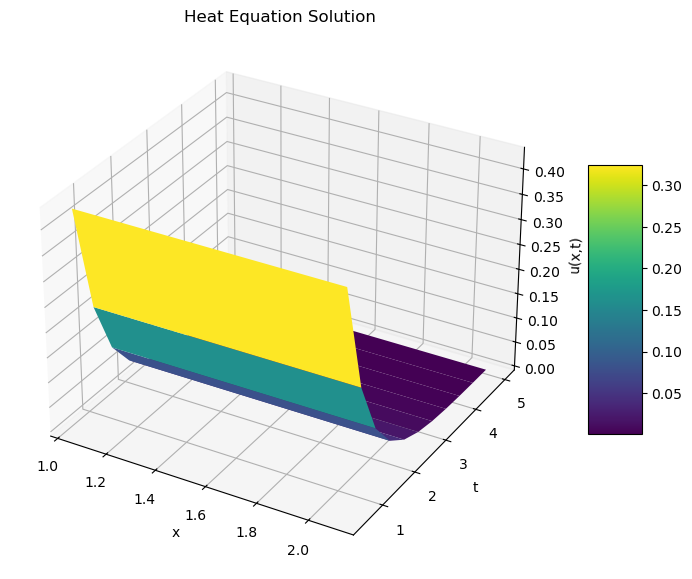

In [198]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

def plot_solution_3d(x_axis, t_axis, u_grid):
    """
    Plot 3D surface of solution (interactive).
    
    Args:
        x_axis: 1D array of x values
        t_axis: 1D array of t values
        u_grid: 2D array of shape (len(x_axis), len(t_axis))
    """
    X, T = np.meshgrid(x_axis, t_axis, indexing='ij')
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, T, u_grid, cmap='viridis')
    
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x,t)')
    ax.set_title('Heat Equation Solution')
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()

# Usage with your data:
x_grid, t_grid, u_grid, h_x, h_t = u_grids[8]  # pick a solution
plot_solution_3d(x_grid, t_grid, u_grid)

# Error calculation setup

In [208]:
def relative_error(x_grid, t_grid, u_grid, fn):
    # print(f"x_grid: {x_grid}")
    gt_samples = np.array([
        [fn(x, t) for t in t_grid]
    for x in x_grid])
    # print(f"u shape: {u_grid.shape}")
    errors = gt_samples - u_grid
    err_norm = np.linalg.norm(errors, axis=1)
    solution_norm = np.linalg.norm(gt_samples, axis=1)
    # print(f"u norm: {solution_norm}, err : {err_norm}")
    # print(f"div: {err_norm / solution_norm}")
    # print(f"gt norm: {np.linalg.norm(gt_samples)}")
    return err_norm / solution_norm

In [212]:
def find_rel_err_under(percent=0.02):
    for s in u_grids:
        x_grid, t_grid, u_grid, h_x, h_t = s
        rel_err_vec = relative_error(x_grid, t_grid, u_grid, gt_fn)
        infinte_norm = np.max(rel_err_vec)
        print(f"h_x: {h_x}, h_t: {h_t} max: {infinte_norm}")

        
        if infinte_norm <= percent:
            return s
    return None
    

In [213]:
print(find_rel_err_under())

h_x: 0.31622776601683794, h_t: 0.05 max: 0.14971306493257633
h_x: 0.4472135954999579, h_t: 0.1 max: 0.030853116357942988
h_x: 0.5477225575051662, h_t: 0.15000000000000002 max: 0.23520287132692316
h_x: 0.6324555320336759, h_t: 0.2 max: 0.37331655932414004
h_x: 0.7071067811865476, h_t: 0.25 max: 0.24179206172343756
h_x: 0.7745966692414834, h_t: 0.3 max: 0.08394258052690926
h_x: 0.8366600265340756, h_t: 0.35000000000000003 max: 0.47477585353237806
h_x: 0.8944271909999159, h_t: 0.4 max: 0.3927639078516978
h_x: 0.9486832980505138, h_t: 0.45 max: 0.34045081093900265
h_x: 1.0, h_t: 0.5 max: 0.2773204361729722
None
